# Requirements and imports

In [ ]:
!pip install -r requirements.txt

In [19]:
from time import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from  scipy import optimize

from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sktime.datasets import load_airline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


from utils import get_best_lags_kernels,h_step_forecast
from utils import sliding_windows,LSTM
from utils import MA,calculate_R2_adjusted,calculate_R2,split_train_test,find_best_q_for_ma

#from TS_Extrinsic_Regression.models.rocket import generate_kernels,apply_kernels
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


SyntaxError: invalid syntax (2862717994.py, line 24)

# Data

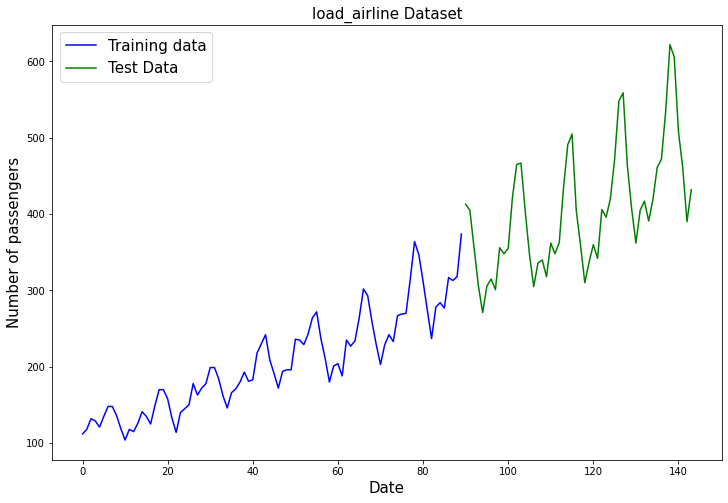

In [44]:
y = load_airline()

#y_train, y_test = split_train_test(y.to_numpy())
train_size=90
y_train, y_test=y[:train_size],y[train_size:]
plt.figure(figsize=(12,8))
plt.plot(range(0,train_size),y_train.values ,label='Training data', c='b')
plt.plot(range(train_size,y.shape[0]),y_test.values, label='Test Data', c='g')
plt.legend(fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Number of passengers',fontsize=15)
plt.title('load_airline Dataset',fontsize=15)
plt.show()

# Moving Average

## Selection of best MA(q) model
*Model is selected on the basis of $R^2$-adjusted  of 1-step ahead forecast*

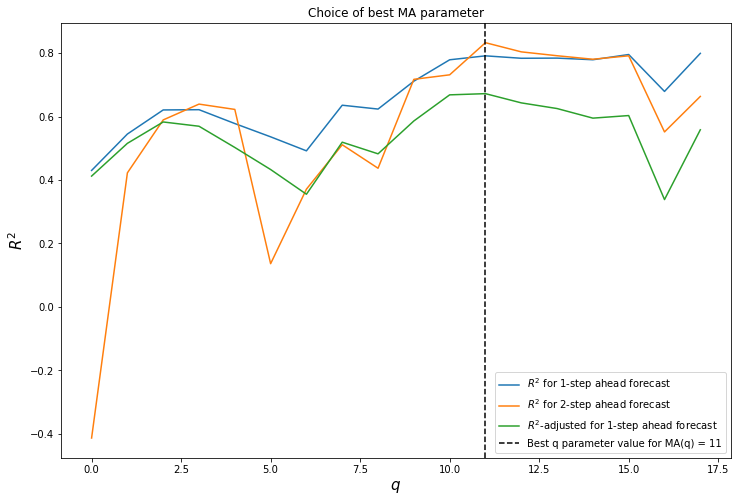

In [9]:
best_q,times=find_best_q_for_ma(1,19,y_train.values,y_test.values)

## Forecast results of best MA(q) model

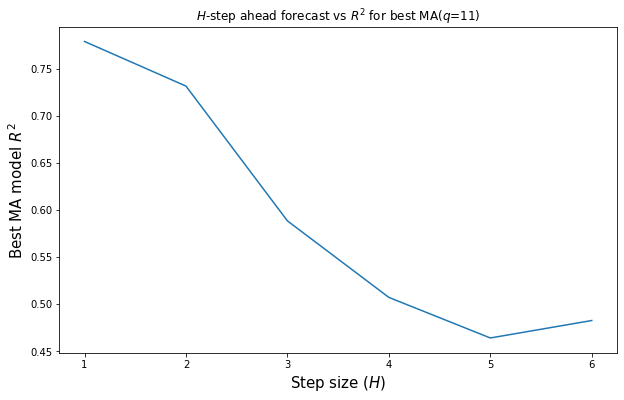

In [14]:
ma_model = MA(q=best_q)
ma_model.fit(y_train.values)
R2_steps = []
for i in range(1, 7):
    R2_steps.append(calculate_R2(ma_model, y_test.values, step=i))
plt.figure(figsize=(10, 6))
plt.plot(range(1, 7), R2_steps);
plt.ylabel("Best MA model $R^2$ ", fontsize=15)
plt.xlabel("Step size ($H$)", fontsize=15);
plt.title(f'$H$-step ahead forecast vs $R^2$ for best MA($q$={best_q})')
plt.show()


## Training Time Complexity of MA(q)

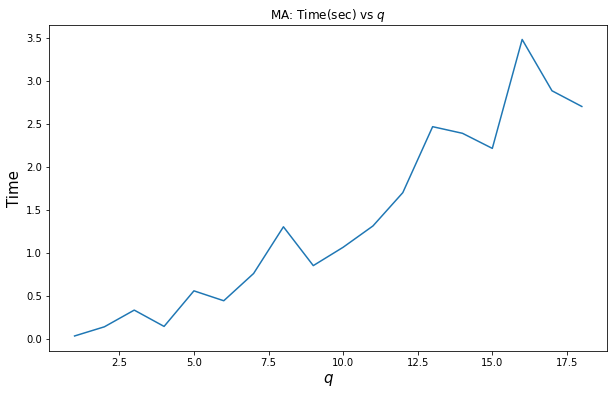

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 19), times)
plt.title('MA: Time(sec) vs $q$')

plt.ylabel("Time", fontsize=15)
plt.xlabel('$q$',fontsize=15);

# XGBoost

# LSTM


### Data

In [2]:
df = load_airline()
df = df.to_frame()
names = ['Period', 'Number of airline passengers']
new_names = ['period', 'number']
df = df.rename(columns={names[0]:new_names[0], names[1]:new_names[1]})
torch.manual_seed(1337)

### Model

In [3]:
sc = MinMaxScaler()
training_data = sc.fit_transform(df['number'].values.reshape(-1, 1))

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = 90

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

print(training_data.shape)
print(dataX.shape)
print(dataY.shape)
print(trainX.shape)
print(trainY.shape)

(144, 1)
torch.Size([139, 4, 1])
torch.Size([139, 1])
torch.Size([90, 4, 1])
torch.Size([90, 1])


### Training

In [4]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
t = time()
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

print('\n########################### \n')
print(f'Training time: {time()-t:.4} seconds')

Epoch: 0, loss: 0.60780
Epoch: 100, loss: 0.01225
Epoch: 200, loss: 0.00607
Epoch: 300, loss: 0.00295
Epoch: 400, loss: 0.00276
Epoch: 500, loss: 0.00263
Epoch: 600, loss: 0.00249
Epoch: 700, loss: 0.00235
Epoch: 800, loss: 0.00222
Epoch: 900, loss: 0.00211
Epoch: 1000, loss: 0.00200
Epoch: 1100, loss: 0.00192
Epoch: 1200, loss: 0.00184
Epoch: 1300, loss: 0.00179
Epoch: 1400, loss: 0.00175
Epoch: 1500, loss: 0.00172
Epoch: 1600, loss: 0.00170
Epoch: 1700, loss: 0.00168
Epoch: 1800, loss: 0.00167
Epoch: 1900, loss: 0.00167

########################### 

Training time: 0.9495 seconds


### Inference

R-squared on Test Data for LSTM is 0.693115893953317


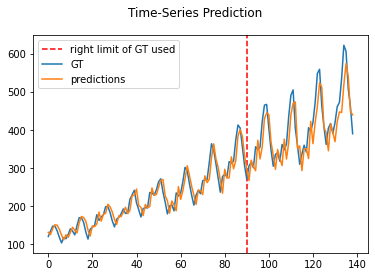

In [18]:
lstm.eval()

# predict on training and test data
all_predict = lstm(dataX)

data_predict = all_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

print(f'R-squared on Test Data for LSTM is {r2_score(dataY_plot[train_size:],data_predict[train_size:])}')
plt.axvline(x=train_size, c='r', linestyle='--', label='right limit of GT used')

plt.plot(dataY_plot, label='GT')
plt.plot(data_predict, label='predictions')
plt.suptitle('Time-Series Prediction')
plt.legend()
plt.show()
     

In [ ]:
r2_score()

# Rocket

## Search for the best number of kernels and number of lags to use

In [27]:
diff_kernels=[1000,5000,10000,20000,50000,100000,200000]
results_r2=[]
results_time=[] 
results_r2,results_time=get_best_lags_kernels(8,13,diff_kernels,y,train_size)
r2_df=pd.DataFrame(results_r2)
time_df=pd.DataFrame(results_time)
r2_df.columns=['num_kernels','num_lags','r2']
time_df.columns=['num_kernels','num_lags','time']
r2_df_sorted=r2_df.sort_values(by='r2',ascending=False)
r2_df_sorted.head(3)


,num_kernels,num_lags,r2
22,5000,11,0.917362
27,200000,11,0.916842
16,10000,10,0.916507


## $R^2$ dependence on Number of lags, Number of kernels used

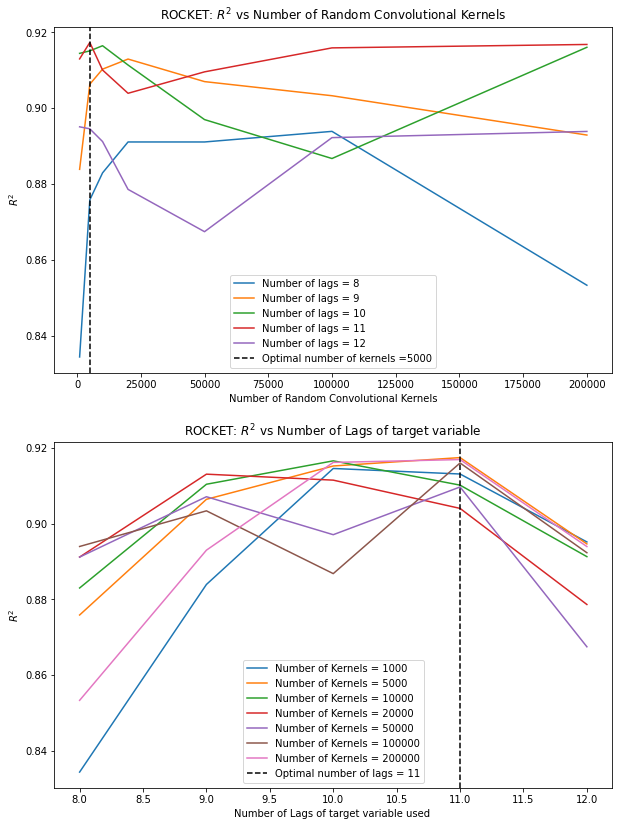

In [34]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,14))
for n in r2_df.num_lags.unique():
    ax1.plot(r2_df[r2_df.num_lags==n].num_kernels,r2_df[r2_df.num_lags==n].r2,label=f'Number of lags = {n}')
ax1.set_xlabel('Number of Random Convolutional Kernels')
ax1.set_ylabel('$R^2$')
ax1.axvline(r2_df_sorted.head(1).num_kernels.values[0],ls='--',c='k',label=f'Optimal number of kernels ={r2_df_sorted.head(1).num_kernels.values[0]}')


ax1.set_title('ROCKET: $R^2$ vs Number of Random Convolutional Kernels ')
ax1.legend()

for n in r2_df.num_kernels.unique():
    ax2.plot(r2_df[r2_df.num_kernels==n].num_lags,r2_df[r2_df.num_kernels==n].r2,label=f'Number of Kernels = {n}')
ax2.set_xlabel('Number of Lags of target variable used ')
ax2.set_ylabel('$R^2$')
ax2.set_title('ROCKET: $R^2$ vs Number of Lags of target variable ')
ax2.axvline(r2_df_sorted.head(1).num_lags.values[0],ls='--',c='k',label=f'Optimal number of lags = {r2_df_sorted.head(1).num_lags.values[0]}')

ax2.legend(loc=8)
plt.show()


## Forecasts

## 1-step and 2-step ahead forecasts

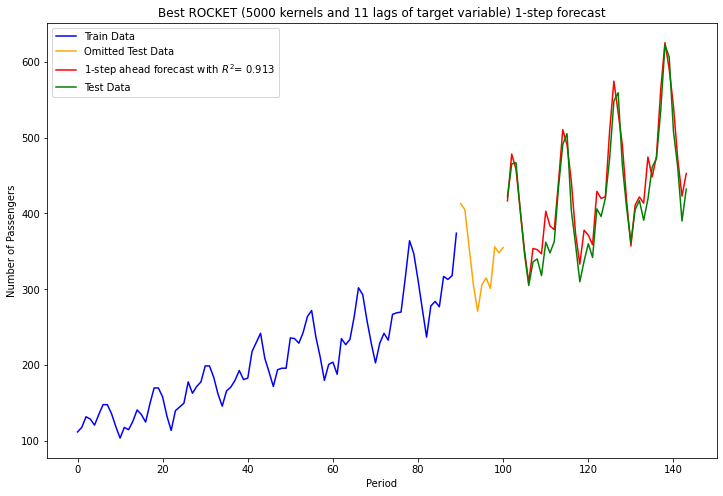

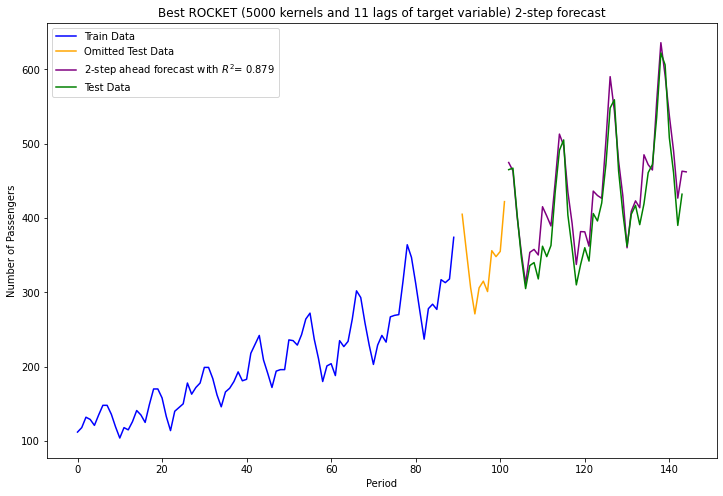

In [72]:
from TS_Extrinsic_Regression.models.rocket import generate_kernels,apply_kernels
from time import time
np.random.seed=13
n_kernels=r2_df_sorted.head(1).num_kernels.values[0]
num_lags=r2_df_sorted.head(1).num_lags.values[0]
forecast_i=[]
one_step_forecast=h_step_forecast(n_kernels,num_lags,y,train_size,1)['pred t+1']
one_step_r2=r2_score(y_test[num_lags:],one_step_forecast)
forecast_i.append(one_step_r2)
plt.figure(figsize=(12,8))
plt.plot(y_train.values,c='b',label='Train Data')
plt.plot(np.arange(train_size,train_size+num_lags),y_test[:num_lags].values,c='orange',label='Omitted Test Data ')

plt.plot(np.arange(train_size+num_lags,144),one_step_forecast,label=f'1-step ahead forecast with $R^2$= {np.round(one_step_r2,3)}',c='r')
plt.plot(np.arange(train_size+num_lags,144),y_test[num_lags:].values,label='Test Data',c='g')
plt.legend(loc=2)
plt.ylabel('Number of Passengers')
plt.xlabel('Period')
plt.title('Best ROCKET (5000 kernels and 11 lags of target variable) 1-step forecast')
plt.show()

# 2-step ahead-forecast

two_step_forecast=h_step_forecast(n_kernels,num_lags,y,train_size,2)['pred t+2']
two_step_r2=r2_score(y_test[num_lags+1:],two_step_forecast[:-1])

plt.figure(figsize=(12,8))
plt.plot(y_train.values,c='b',label='Train Data')
plt.plot(np.arange(train_size+1,train_size+num_lags+1),y_test[1:num_lags+1].values,c='orange',label='Omitted Test Data ')

plt.plot(np.arange(train_size+num_lags+1,145),two_step_forecast,label=f'2-step ahead forecast with $R^2$= {np.round(two_step_r2,3)}',c='purple')
plt.plot(np.arange(train_size+num_lags+1,144),y_test[num_lags+1:].values,label='Test Data',c='g')
plt.legend(loc=2)
plt.ylabel('Number of Passengers')
plt.xlabel('Period')
plt.title('Best ROCKET (5000 kernels and 11 lags of target variable) 2-step forecast')
plt.show()

## h-step ahead forecasts

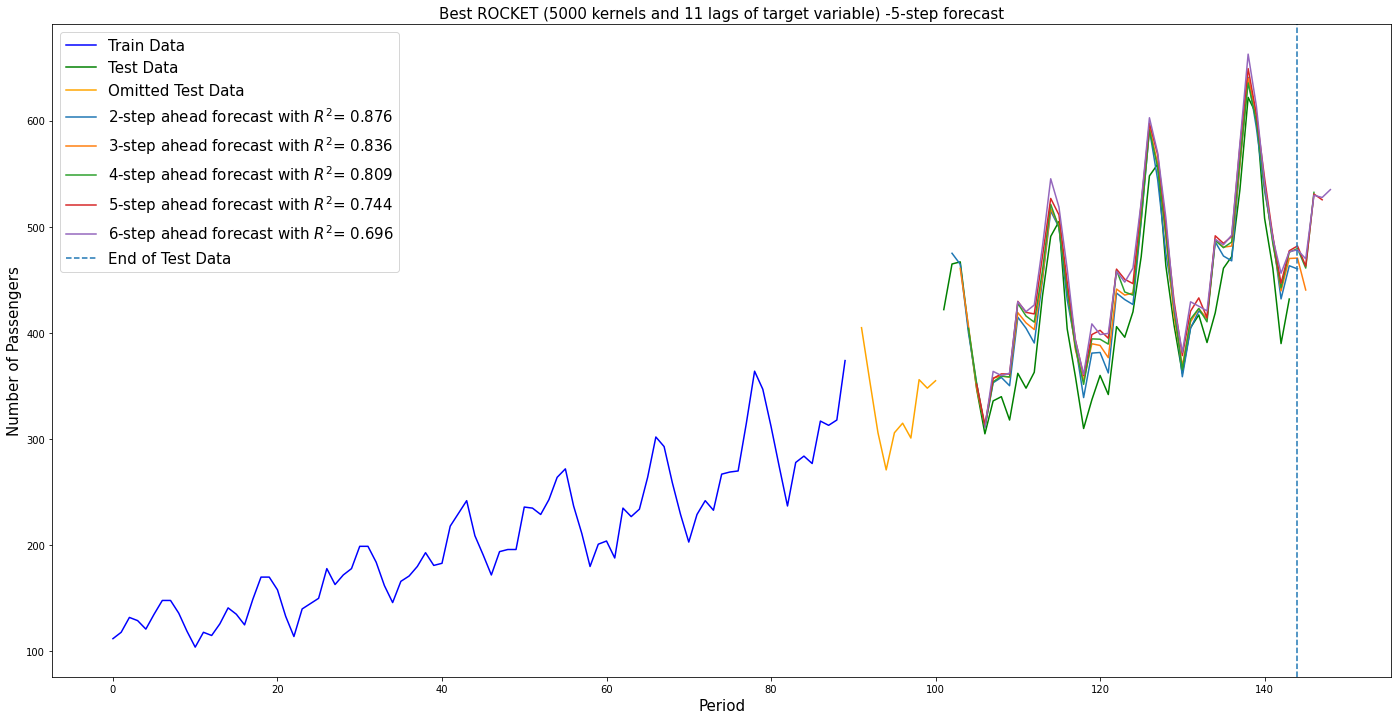

In [73]:
n_kernels=r2_df_sorted.head(1).num_kernels.values[0]
num_lags=r2_df_sorted.head(1).num_lags.values[0]
fig,ax=plt.subplots(1,1,figsize=(24,12))
ax.plot(y_train.values,c='b',label='Train Data')
ax.plot(np.arange(train_size+num_lags,144),y_test[num_lags:].values,label='Test Data',c='g')
ax.plot(np.arange(train_size+1,train_size+num_lags),y_test[1:num_lags].values,c='orange',label='Omitted Test Data ')
for i in range(2,7):
    forecast=h_step_forecast(n_kernels,num_lags,y,train_size,i)[f'pred t+{i}'].values
    h_step_r2=r2_score(y_test[num_lags+i-1:],forecast[:-i+1])

    forecast_i.append(h_step_r2)
    ax.plot(np.arange(train_size+num_lags+i-1,144+i-1),forecast,label=f'{i}-step ahead forecast with $R^2$= {np.round(h_step_r2,3)}')
    ax.set_ylabel('Number of Passengers',fontsize=15)
    ax.set_xlabel('Period',fontsize=15)
ax.set_title(f'Best ROCKET (5000 kernels and 11 lags of target variable) {1-6}-step forecast',fontsize=15)
    #ax.text(x=20,y=550,s=f'$R^2$={np.round(h_step_r2,3)}', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))
ax.axvline(x=144,ls='--',label='End of Test Data')
ax.legend(loc=2,fontsize=15)

plt.show()

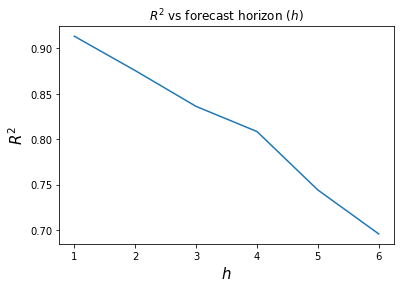

In [74]:
plt.plot(np.arange(1,7),forecast_i)
plt.xlabel('$h$',fontsize=15)
plt.ylabel('$R^2$',fontsize=15)
plt.title('$R^2$ vs forecast horizon ($h$)',fontsize=12)

plt.show()


## Training Time Complexity

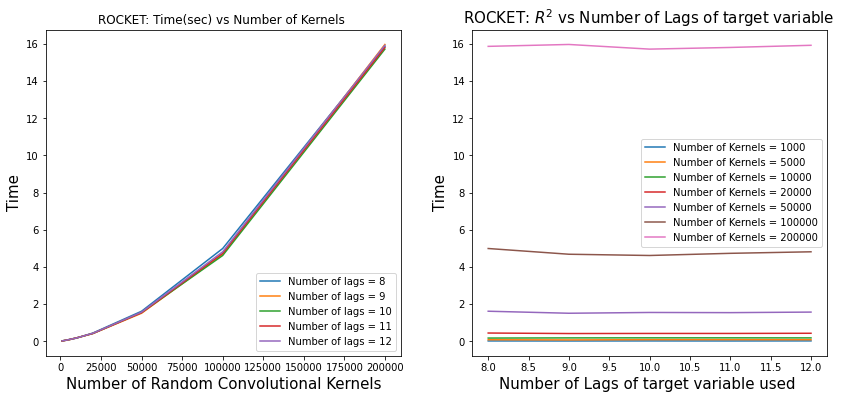

In [80]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(14,6))
for n in time_df.num_lags.unique():
    ax1.plot(time_df[time_df.num_lags==n].num_kernels,time_df[time_df.num_lags==n].time,label=f'Number of lags = {n}')
ax1.set_xlabel('Number of Random Convolutional Kernels',fontsize=15)
ax1.set_ylabel('Time',fontsize=15)
ax1.set_title('ROCKET: Time(sec) vs Number of Kernels ',fontsize=12)
ax1.legend(loc=4)

for n in time_df.num_kernels.unique():
    ax2.plot(time_df[time_df.num_kernels==n].num_lags,time_df[time_df.num_kernels==n].time,label=f'Number of Kernels = {n}')
ax2.set_xlabel('Number of Lags of target variable used ',fontsize=15)
ax2.set_ylabel('Time',fontsize=15)
ax2.set_title('ROCKET: $R^2$ vs Number of Lags of target variable ',fontsize=15)
ax2.legend()

plt.show()

# References добавить
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7951134/

https://github.com/angus924/rocket